# Sniffer Classifer
- Author: Sharon Fitzpatrick 
- Date April 2022
</br>
</br>
CNN that distinguishes between "good" and "bad" imagery. Based on the image sorting tool Sniffer. Intended purpose is to quickly sort through geospatial imagery and filter out bad imagery such as images with large segments missing, cloudy  images, or images with errors.

In [1]:
import matplotlib.pyplot as plt
from skimage import io

import glob
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives,TruePositives, Precision, Recall, AUC

# Allows for matplot's to be displayed inline
%matplotlib inline

## Local Variables
Use these variables to change the training parameters for your CNN.
- `dataset_path`: directory containing the  unzipped imagery
- `img_shape` : shape (width , height) your imagery will be resized to. These are inputs into the model.
- `imgs`: list containing all the jpgs  the model will be trained on

In [2]:
dataset_path=os.getcwd()+os.sep+"images"
imgs=glob.glob(dataset_path+os.sep+"*.jpg")
img_shape=(100, 100)
print("In {0} there are {1:n} images".format(dataset_path,len(imgs)))

In c:\1_USGS\2_Machine_Learning\3_sniffer_classifier\Sniffer-Classifier\images there are 1516 images


## Augmenting the Dataset
Create an image generator to apply augmentations to the imagery.
- standardizes the image sizes 
- applies zooms, flips, rotations to the imagery

In [3]:
train_datagen=ImageDataGenerator(
samplewise_std_normalization=True,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest",
validation_split=0.20
)
# Not used at all in the code
test_datagen=ImageDataGenerator(samplewise_std_normalization=True,)


# Read in the  csv file and transform in df
1. Read in the csv
2. Clean the csv by dropping unused columns
3. Encode the categorical labels to binary labels consisting of 0 and 1

In [4]:
def clean_csv(csv: str):
    """Takes in the name of the csv file to clean (ex. 'master.csv') and a list labels to one hot encode.
        Returns the modified dataframe.
    """
    df =  pd.read_csv(csv)
    if "index" in df.columns:
        print("Dropping column index")
        df.drop(['index'],axis=1,inplace=True)
    if "Index" in df.columns:
        print("Dropping column Index")
        df.drop(['Index'],axis=1,inplace=True)
    if "Unnamed: 0"in df.columns:
        print("Dropping column Unnamed: 0")
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    if "Unnamed: 0.1"in df.columns:
        print("Dropping column Unnamed: 0.1")
        df.drop(['Unnamed: 0.1'],axis=1,inplace=True)
    return df

In [5]:
def binary_encode_labels(df:'pandas.core.frame.DataFrame',labels=["bad","good"]):
  """ Returns the modified dataframe with the labels encoded as binary labels of 0 and 1"""
  mapping = {}
  df["Filename"]=df["Filename"].astype(str)
  df["Sorted"]=df["Sorted"].astype(str)
  if df["Sorted"].str.contains('|'.join( ["good","bad"])).any():
    for x in range(len(labels)):
      mapping[labels[x]] = x
    # outputs {'good': 0, 'bad': 1}
    # Replace each label in sorted with corresponding one hot encoded label
    for x in range(len(df['Sorted'])):
      df['Sorted'][x] = mapping[df['Sorted'][x]]
    df["Sorted"]=df["Sorted"].astype(str)
  return df

In [6]:
def prep_dataset(csv:str):
    # Clean the dataset read from the csv file
    df=clean_csv(csv)
    # Encode the categorical labels to binary labels of 0 and 1
    df=binary_encode_labels(df)
    return df

In [7]:
df=prep_dataset("master.csv")
df

Dropping column Unnamed: 0


,Filename,Sorted
0,2000-01-07-18-21-07_L5_rgb.jpg,0
1,2000-04-12-18-20-29_L5_rgb.jpg,0
2,2000-04-28-18-21-24_L5_rgb.jpg,1
3,2000-08-02-18-23-18_L5_rgb.jpg,0
4,2000-08-18-18-23-46_L5_rgb.jpg,1
...,...,...
1511,2018-12-31-16-35-16_S2_ID12022-05-09.jpg,0
1512,2018-12-31-16-35-16_S2_ID52022-05-09.jpg,0
1513,2018-12-31-16-35-16_S2_ID32022-05-09.jpg,0
1514,2018-12-31-16-35-16_S2_ID42022-05-09.jpg,0


## Random OverSampling
Currently the dataset is imbalanced because the number of good and bad samples are not equal to each other.
Use Random oversampling so that the the number of samples in both classes are equal.

In [8]:
def random_oversampling(df,over_sample_class):
    """Apply random oversampling to the dataframe"""
    # Count the number of entries in both classes
    class_count_1,class_count_0=df['Sorted'].value_counts()['1'],df['Sorted'].value_counts()['0']
    # Divide the dataframe into the two classes
    class_0_df=df[df["Sorted"]=='0']
    # print(class_0_df)
    class_1_df=df[df["Sorted"]=='1']
    # print(class_1_df)
    # Oversample the the dataframe
    if over_sample_class == 0:
        # Oversample the 0 class by taking the class_0_df and use the df.sample() to create class_count_1 samples
        class_over_0=class_0_df.sample(class_count_1,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_over_0,class_1_df],axis=0)
    elif over_sample_class == 1:
         # Oversample the 1 class by taking the class_1_df and use the df.sample() to create class_count_0 samples
        class_over_1=class_1_df.sample(class_count_0,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_0_df,class_over_1],axis=0,ignore_index=True)
    return df

In [9]:
def apply_random_oversampling(df):
    """Apply random oversampling to the class with the least amount of samples"""
    labels=df['Sorted'].value_counts().index.tolist()
    if any("0" in word for word in labels ) and any("1" in word for word in labels):
        class_count_1,class_count_0=df['Sorted'].value_counts()['1'],df['Sorted'].value_counts()['0']
        if class_count_0 < class_count_1:
            # oversample class_count_0
            df=random_oversampling(df,0)
        elif  class_count_0 > class_count_1:
            # oversample class_count_1
            df=random_oversampling(df,1)
    return df

## Create the Data Generators
---

In [12]:
def get_training_dataframes(df):
    """Returns the training and test dataframes
    Splits the dataframe int a .75 and .25 training and test set respectively"""
    # Convert the sorted column to string otherwises data generators will not work
    df["Sorted"]=df["Sorted"].astype(str)
    # Shuffle the entries in the pandas dataframe
    shuffled_df=df.sample(frac=1,random_state=1).reset_index()
    # Split the dataframe into a train and test set into a .75 and .25 training and test set respectively
    # get the first 500 rows
    # traindf=shuffled_df.iloc[:500,:]
    traindf=shuffled_df.iloc[:1514,:]
    # get the remaining rows
    # testdf=shuffled_df.iloc[500:,:]
    testdf=shuffled_df.iloc[1514:,:]
    # Balance the traindf and testdf datasets
    traindf=apply_random_oversampling(traindf)
    testdf=apply_random_oversampling(testdf)
    traindf.drop(['index'],axis=1,inplace=True)
    testdf.drop(['index'],axis=1,inplace=True)
    return  traindf,testdf

In [13]:
traindf,testdf=get_training_dataframes(df)
traindf,testdf

c:\Users\Sharon\anaconda\envs\machine_learning\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(                                      Filename Sorted
 0               2021-05-31-18-52-00_L8_rgb.jpg      0
 1               2007-05-18-18-40-32_L5_rgb.jpg      0
 2     2018-12-23-15-43-31_L7_ID42022-05-10.jpg      0
 3     2018-12-23-16-25-15_S2_ID42022-05-09.jpg      0
 4     2018-12-16-16-34-56_S2_ID42022-05-09.jpg      0
 ...                                        ...    ...
 1537            2009-04-05-18-33-04_L5_rgb.jpg      1
 1538            2009-01-31-18-31-35_L5_rgb.jpg      1
 1539  2018-12-18-16-25-18_S2_ID22022-05-09.jpg      1
 1540  2018-12-02-16-06-26_S2_ID12022-05-09.jpg      1
 1541  2018-12-13-17-16-05_S2_ID62022-05-09.jpg      1
 
 [1542 rows x 2 columns],
                                       Filename Sorted
 1514            2015-09-20-18-52-13_L8_rgb.jpg      1
 1515  2018-12-12-16-04-06_S2_ID32022-05-10.jpg      1)

0    771
1    771
Name: Sorted, dtype: int64


<AxesSubplot:title={'center':'Count(target)'}>

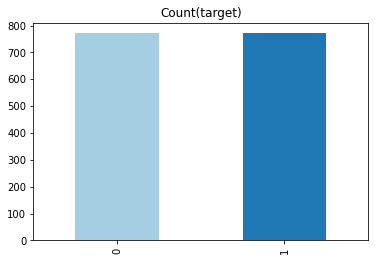

In [14]:
print(traindf['Sorted'].value_counts(ascending=True))
traindf['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(traindf))))

In [ ]:
print(testdf['Sorted'].value_counts())
testdf['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(testdf))))

In [15]:
def get_column_names(df):
    """ x (data) and y (labels) column names from the dataframe """
    x_col_name=df.columns[0]
    y_col_name=df.columns[1]
    return x_col_name,y_col_name

## Flow the images from the dataframe
- resize the images 
- shuffle the images
- divide the data into a training and validation subset
- set a random seed

In [26]:
# traindf,testdf=get_training_dataframes(df)
x_col_name,y_col_name=get_column_names(df)

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name,   # image filenames
y_col=y_col_name,   # labels 
subset="training",
batch_size=24,
seed=42,
shuffle=True,
class_mode="binary",
target_size=img_shape)


Found 1234 validated image filenames belonging to 2 classes.


In [27]:

valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, 
y_col=y_col_name, 
subset="validation", 
batch_size=22, 
seed=42,
shuffle=True,
class_mode="binary",
target_size=img_shape)

Found 308 validated image filenames belonging to 2 classes.


## Create the Model
----
Create a simple Sequential Model

In [42]:
def prepare_model():
    # metrics=[TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name="BinaryAccuracy"), Precision(name="precision"), Recall(name="recall"),AUC(name="AUC")]
    metrics=[BinaryAccuracy(name="binary_accuracy"), Recall(name="recall")]
    model = keras.Sequential()
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=img_shape+(3,)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=metrics)
    return model

In [43]:
model = prepare_model()

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)      

In [45]:
history=model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=20)

Epoch 1/20
51/51 [==============================] - 20s 359ms/step - loss: 0.5304 - binary_accuracy: 0.7471 - recall: 0.9313 - val_loss: 0.4512 - val_binary_accuracy: 0.8393 - val_recall: 0.9858
Epoch 2/20
51/51 [==============================] - 18s 355ms/step - loss: 0.3417 - binary_accuracy: 0.8717 - recall: 0.9738 - val_loss: 0.3347 - val_binary_accuracy: 0.8661 - val_recall: 0.9857
Epoch 3/20
51/51 [==============================] - 18s 352ms/step - loss: 0.3203 - binary_accuracy: 0.8843 - recall: 0.9813 - val_loss: 0.3389 - val_binary_accuracy: 0.8661 - val_recall: 0.9662
Epoch 4/20
51/51 [==============================] - 21s 419ms/step - loss: 0.3164 - binary_accuracy: 0.8826 - recall: 0.9802 - val_loss: 0.2969 - val_binary_accuracy: 0.8869 - val_recall: 1.0000
Epoch 5/20
51/51 [==============================] - 19s 371ms/step - loss: 0.3088 - binary_accuracy: 0.8926 - recall: 0.9908 - val_loss: 0.3160 - val_binary_accuracy: 0.9048 - val_recall: 0.9825
Epoch 6/20
51/51 [=======

## Evaluate Model Performance
---

In [46]:
score = model.evaluate(valid_generator)
print(score)

14/14 [==============================] - 4s 281ms/step - loss: 0.3518 - binary_accuracy: 0.7890 - recall: 0.0000e+00
[0.3518248200416565, 0.7889610528945923, 0.0]


In [47]:
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,binary_accuracy,recall,val_loss,val_binary_accuracy,val_recall
0,0.530401,0.747107,0.931308,0.451232,0.839286,0.985782
1,0.341675,0.871732,0.973753,0.334720,0.866071,0.985714
2,0.320263,0.884298,0.981333,0.338887,0.866071,0.966184
3,0.316431,0.882645,0.980185,0.296891,0.886905,1.000000
4,0.308805,0.892562,0.990826,0.316024,0.904762,0.982456
5,0.346393,0.874380,0.976190,0.276081,0.907738,0.990566
6,0.299322,0.890083,0.990704,0.293019,0.880952,0.995261
7,0.286011,0.897521,0.986720,0.269469,0.901786,0.986239
8,0.291159,0.893388,0.984043,0.268268,0.907738,1.000000
9,0.298152,0.894215,0.990765,0.315277,0.880952,0.980488


### Plot some graphs to evaluate the model performance

<AxesSubplot:>

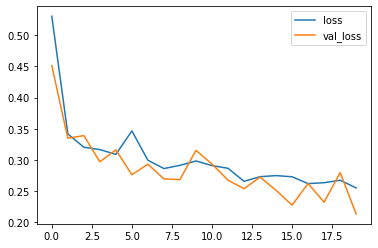

In [48]:
metrics_df[["loss","val_loss"]].plot()

<AxesSubplot:>

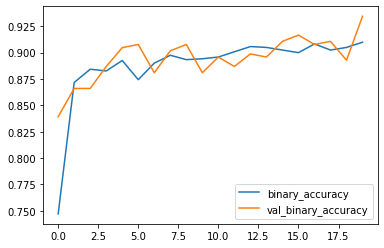

In [50]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot()


<AxesSubplot:>

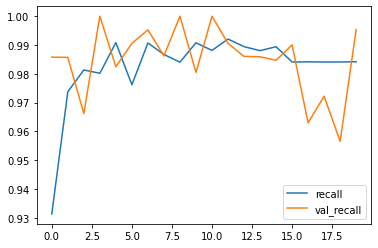

In [51]:
metrics_df[["recall","val_recall"]].plot()

<AxesSubplot:>

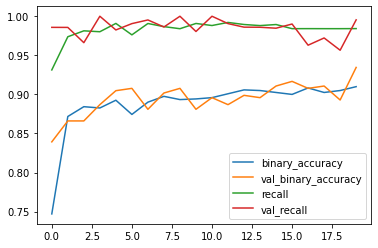

In [52]:
metrics_df[["binary_accuracy","val_binary_accuracy","recall","val_recall"]].plot()

## Save the Model and Training Metrics
1. Create a folder with the name of the model the user provides to store all the data in
2. Save the metrics dataframe as a csv
3. Save the actual model

In [53]:
def save_model_data(model_name:str,model:'keras.engine.sequential.Sequential',metrics_df:pd.DataFrame):
    # Create a directory to store all the model data
    model_save_path=os.getcwd()+os.sep+"models"
    if not os.path.exists(model_save_path):
        os.mkdir(model_save_path)
    model_save_path=os.getcwd()+os.sep+"models"+os.sep+model_name
    if os.path.exists(model_save_path):
        raise FileExistsError(f"This folder '{model_name}' already exists: {model_save_path}.\n Please rename your model.")
    else:
        os.mkdir(model_save_path)
    # Save the model history (training metrics) to csv
    metrics_df.to_csv(model_save_path+ os.sep+"model_metrics.csv",index=False)
    # Save the actual model
    model.save(model_save_path+os.sep+"model")

In [54]:
# Enter the name of your model
model_name="binary_classification_model_v_2_3"
# This might take a few seconds
save_model_data(model_name,model,metrics_df)

INFO:tensorflow:Assets written to: c:\1_USGS\2_Machine_Learning\3_sniffer_classifier\Sniffer-Classifier\models\binary_classification_model_v_2_3\model\assets
